In [1]:
import pyarrow.parquet as pa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from category_encoders import BinaryEncoder
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.cm as cm
import os
from typing import Tuple, Union, Callable
from pcaautoencoder import *

In [2]:
# Dataset for tabular data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
# Loading data
inputFeature = pd.read_csv('../Data/NIBRS_ND_2021/processed/input.csv', index_col='Unnamed: 0')
# Separating numerical and categorical features
numerical_features=['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear']
categorical_features = ['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend']
# Onehot-encoding categorical features
inputFeature_1h = pd.get_dummies(inputFeature, columns=categorical_features)

In [4]:
categorymapper = {
    "all_columns" : categorical_features,
    "all_indices" : [],
    "columns": {},
    "values": {}
}

for column in inputFeature_1h.columns:
    splitted_colname = column.split(" ")
    double_splitted_colname = splitted_colname[0].split("_")
    original_colname = "_".join(double_splitted_colname[:-1])
    if original_colname in categorical_features:
        first_value = double_splitted_colname[-1:]
        column_value = " ".join(first_value + splitted_colname[1:])
        column_index = inputFeature_1h.columns.get_loc(column)
        categorymapper["all_indices"].append(column_index)
        categorymapper["columns"].update({column_index:original_colname})
        categorymapper["values"].update({column_index:column_value})

In [5]:
# all_dummydict = {}
# def gotrough_pt(X: torch.Tensor, window_size: int):
#     for i in range(int(np.ceil(X.shape[0] / window_size))):
#         if window_size * (i + 1) < X.shape[0]:
#             yield X[i*window_size:(i+1)*window_size, :]
#         else:
#             yield X[i*window_size:, :]

# # dummydict = remap_metadata_pt(torch.Tensor(inputFeature_1h.to_numpy()), categorymapper)
# # dummylist = list(zip(*dummydict.values()))
# # dummylist[0]
# for window in gotrough_pt(torch.Tensor(inputFeature_1h.to_numpy()), 32):
#     # print(window.shape)
#     dummydict = remap_metadata_pt(window, categorymapper)
#     for key, value in dummydict.items():
#                             if key in all_dummydict:
#                                 all_dummydict[key] += value
#                             else:
#                                 all_dummydict[key] = value

In [6]:
# Convert object columns to numeric if they represent categories
for column in inputFeature_1h.select_dtypes(include=['object']):
    inputFeature_1h[column] = inputFeature_1h[column].astype('category').cat.codes

# Train-test split
train, test = train_test_split(inputFeature_1h, test_size=0.1, random_state=42)

# Normalizing numerical features
for feature in numerical_features:
  train[feature] = (train[feature] - train[feature].min()) / (train[feature].max() - train[feature].min())
  test[feature] = (test[feature] - test[feature].min()) / (test[feature].max() - test[feature].min())

# Converting data to tensors
X_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))
y_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))

X_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))
y_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))

In [7]:
# Dataloaders
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [8]:
# Define sizes for the layers
layer_sizes = [227, 64, 32]  # Example decreasing sizes for the encoder

# Create the encoder ModuleList
encoder = nn.ModuleList()
for i in range(len(layer_sizes) - 1):
    encoder.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
    encoder.append(nn.ReLU())

# Create the decoder ModuleList (mirror of the encoder)
decoder = nn.ModuleList()
decoder.append(nn.Linear(1, layer_sizes[len(layer_sizes) - 1]))
for i in range(len(layer_sizes) - 1, 0, -1):
    decoder.append(nn.Linear(layer_sizes[i], layer_sizes[i - 1]))
    decoder.append(nn.ReLU())

# Remove the last ReLU from the decoder (optional, depending on use case)
decoder = decoder[:-1]
criterion = PCAAE_Loss(nn.MSELoss())
model = PCAAutoencoder(encoder, decoder, 32)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
print_every = 40
callbacks = [ModelCheckPoint(monitored_metric="val reconstruction loss epoch",
                             minimize_metric=True),
            EarlyStopping(monitored_metric="val reconstruction loss epoch",
                          minimize_metric=True,
                          patience=10)]

In [ ]:
!tensorboard --logdir=runs/ --port=6006 --reload_multifile=true
logs = model.fit(optimizer, criterion, epochs, trainloader, testloader, goal_hidden_dim=5, callbacks=callbacks, save_filename="pcaautoencoder",
                 embed_hidden=True, categorymapper=categorymapper)

2025-04-04 09:35:13.693218: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

E0404 09:35:22.422026 18392 program.py:298] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use


Training with hidden dim: 1
step 40 - train loss: 0.0456, train reconstruction loss: 0.0456, train covariance loss: 0.0000
step 80 - train loss: 0.0252, train reconstruction loss: 0.0252, train covariance loss: 0.0000
step 120 - train loss: 0.0246, train reconstruction loss: 0.0246, train covariance loss: 0.0000
step 160 - train loss: 0.0241, train reconstruction loss: 0.0241, train covariance loss: 0.0000
step 200 - train loss: 0.0236, train reconstruction loss: 0.0236, train covariance loss: 0.0000
step 240 - train loss: 0.0233, train reconstruction loss: 0.0233, train covariance loss: 0.0000
step 280 - train loss: 0.0233, train reconstruction loss: 0.0233, train covariance loss: 0.0000
step 320 - train loss: 0.0235, train reconstruction loss: 0.0235, train covariance loss: 0.0000
step 360 - train loss: 0.0234, train reconstruction loss: 0.0234, train covariance loss: 0.0000
step 400 - train loss: 0.0232, train reconstruction loss: 0.0232, train covariance loss: 0.0000
step 440 - tra

c:\Users\CSANADANSYS\Desktop\NN projekt\crime analysis\Notebooks\pcaautoencoder\callbacks.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.lo

torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([32, 227])
torch.Size([10, 227])
torch.Size([1706, 1])
1706 10
Training with hidden dim: 2
step 40 - train loss: 0.0296, train reconstruction loss: 0.0286, train covariance loss: 0.1013
step 80 - train loss: 0.0228, train reconstruction loss: 0.0221, train covariance loss: 0.0662
step 120 - train loss: 0.0223, train reconstruction loss: 0.0215, train covariance loss: 0.0793
step 160 - train loss: 0.0221, train reconstruction loss: 0.0215, train covariance loss: 0.0598
step 200 - train loss: 0.0224, train reconstruction loss: 0.0214, train covariance loss: 0.0951
step 240 - train loss: 0.0225, train reconstruction loss: 0.0212, train covariance loss: 0.1332
step 280 - train loss: 0.0218, train reconstruction loss: 0.0211, train covariance

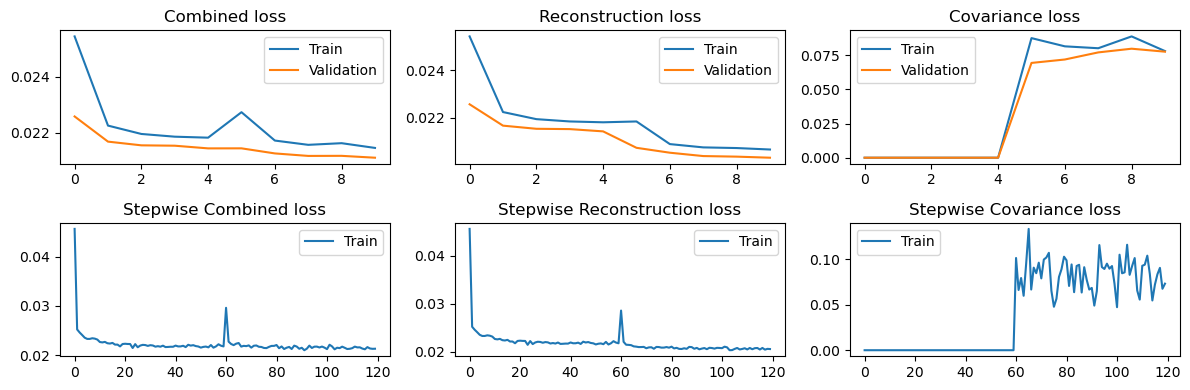

In [10]:
f, ax = plt.subplots(2, 3, figsize=(12, 4))
ax[0, 0].plot(logs["train loss epoch"], label="Train")
ax[0, 0].plot(logs["val loss epoch"], label="Validation")
ax[0, 0].set_title("Combined loss")
ax[0, 0].legend()
ax[0, 1].plot(logs["train reconstruction loss epoch"], label="Train")
ax[0, 1].plot(logs["val reconstruction loss epoch"], label="Validation")
ax[0, 1].set_title("Reconstruction loss")
ax[0, 1].legend()
ax[0, 2].plot(logs["train covariance loss epoch"], label="Train")
ax[0, 2].plot(logs["val covariance loss epoch"], label="Validation")
ax[0, 2].set_title("Covariance loss")
ax[0, 2].legend()
ax[1, 0].plot(logs["train loss step"], label="Train")
ax[1, 0].set_title("Stepwise Combined loss")
ax[1, 0].legend()
ax[1, 1].plot(logs["train reconstruction loss step"], label="Train")
ax[1, 1].set_title("Stepwise Reconstruction loss")
ax[1, 1].legend()
ax[1, 2].plot(logs["train covariance loss step"], label="Train")
ax[1, 2].set_title("Stepwise Covariance loss")
ax[1, 2].legend()

plt.tight_layout()
plt.show()